In [3]:
import yfinance as yf
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


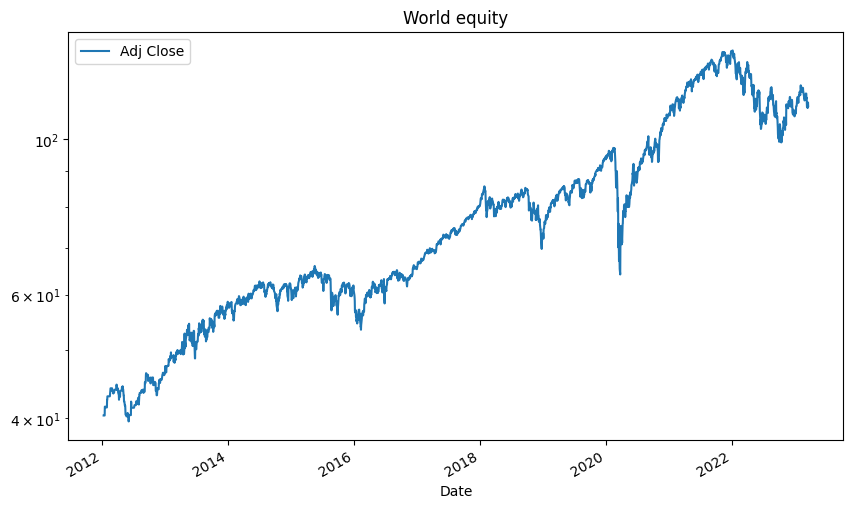

In [4]:
# Download historical data for the ETFs
data = yf.download('URTH', start='2000-01-01')['Adj Close']

# Plot the ETFs in a logarithmic scale
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(ax=ax, logy=True)

# Add a legend
plt.title("World equity")
plt.legend()
# Show the plot
plt.show()

[*********************100%***********************]  6 of 6 completed


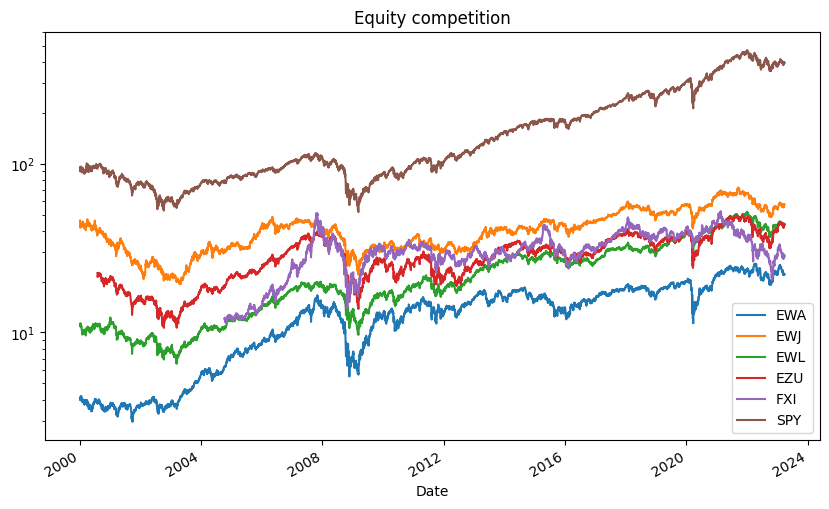

In [5]:
tickers = ['SPY', 'EWJ', 'EZU', 'EWL', 'FXI', 'EWA']


#SPY -> US, EWJ -> Japan, EZU -> Eurozone (to replace with dax and german bonds maybe ), EWL -> switzerland, EWA -> Australia

# Download historical data for the ETFs
data = yf.download(tickers, start='2000-01-01')['Adj Close']

# Plot the ETFs in a logarithmic scale
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(ax=ax, logy=True)

# Add a legend
plt.title("Equity competition")
plt.legend()
# Show the plot
plt.show()

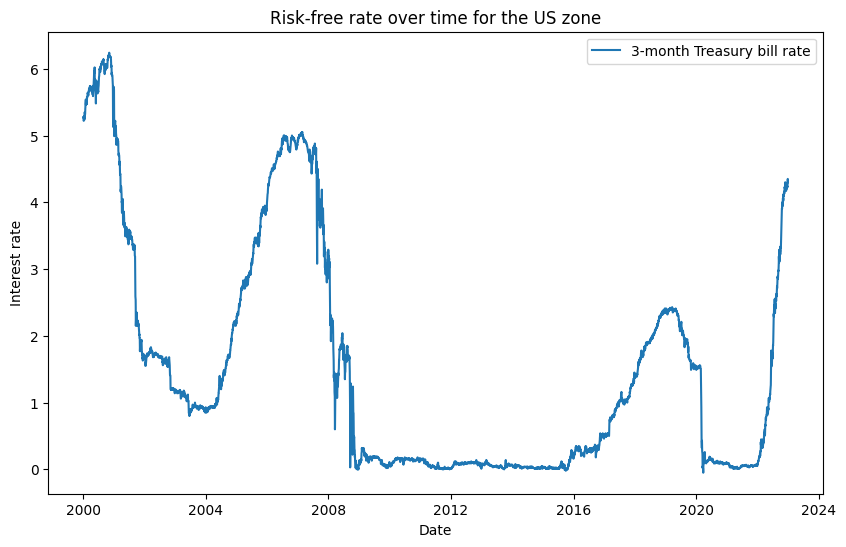

In [12]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

# Set the start and end dates for the data
start_date = '2000-01-01'
end_date = '2022-12-31'

# Use the FRED API to fetch the 3-month Treasury bill rate
risk_free_rate = web.DataReader('DTB3', 'fred', start_date, end_date)

# Remove all rows with NaN values
risk_free_rate.dropna(inplace=True)

# Plot the risk-free rate over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(risk_free_rate.index, risk_free_rate['DTB3'], label='3-month Treasury bill rate')
ax.set_xlabel('Date')
ax.set_ylabel('Interest rate')
ax.set_title('Risk-free rate over time for the US zone')
ax.legend()
plt.show()


In [9]:
import requests
import json

ALPHA_VANTAGE_API_KEY = 'VWNVW6BYE3DIKKEB'  # Replace with your own Alpha Vantage API key
SYMBOL = 'EURIBOR3MD=RR'  # 3-Month Euribor rate

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={SYMBOL}&apikey={ALPHA_VANTAGE_API_KEY}'
response = requests.get(url)

if response.status_code == 200:
    data = json.loads(response.text)
    if 'Time Series (Daily)' in data:
        time_series = data['Time Series (Daily)']
        date = sorted(time_series.keys())[-1]
        risk_free_rate = time_series[date]['4. close']

        print(f'As of {date}, the risk-free rate in the Eurozone is approximately {risk_free_rate}%')
    else:
        print(f'Error: {data.get("Note") or data.get("Information") or data.get("Error Message")}')
else:
    print(f'Error: {response.status_code}')


Error: Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints


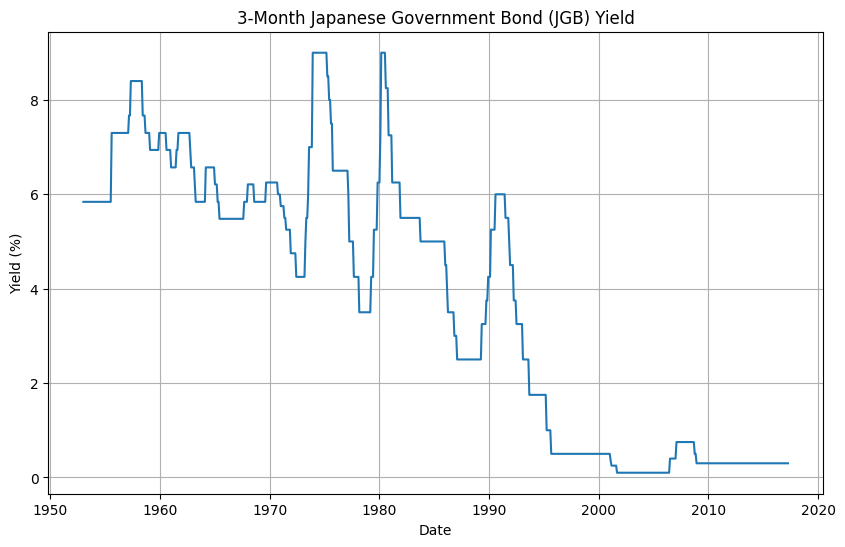

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_api_key' with your actual FRED API key
api_key = '2f15c96b46530fde1b1992a64c64650e'

# FRED API URL for 3-Month Japanese Government Bond (JGB) yield data
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=INTDSRJPM193N&api_key={api_key}&file_type=json'

# Send the request to the API
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    data_points = data['observations']

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data_points, columns=['date', 'value'])
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df['value'])
    plt.title('3-Month Japanese Government Bond (JGB) Yield')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.grid()
    plt.show()

else:
    print(f"Error fetching data. Status code: {response.status_code}")


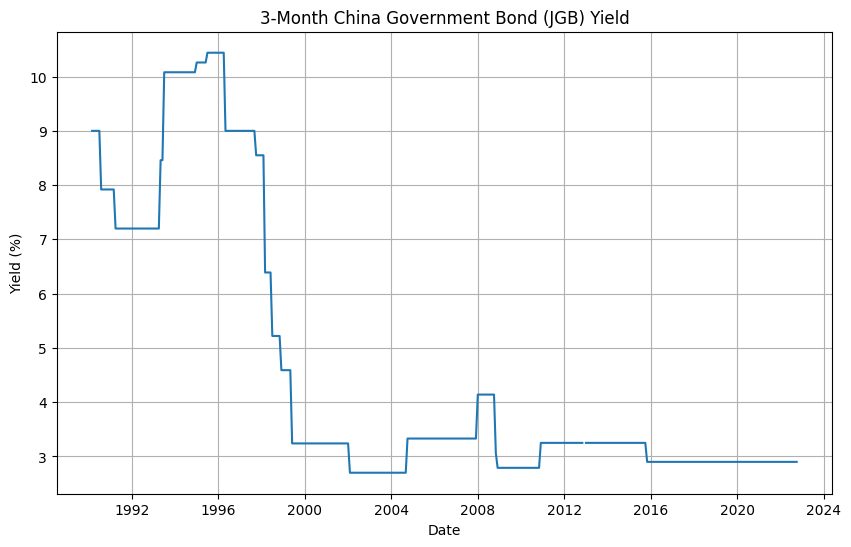

In [7]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_api_key' with your actual FRED API key
api_key = '2f15c96b46530fde1b1992a64c64650e'

# FRED API URL for 3-Month Japanese Government Bond (JGB) yield data
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=INTDSRCNM193N&api_key={api_key}&file_type=json'

# Send the request to the API
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    data_points = data['observations']

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data_points, columns=['date', 'value'])
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df['value'])
    plt.title('3-Month China Government Bond (JGB) Yield')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.grid()
    plt.show()

else:
    print(f"Error fetching data. Status code: {response.status_code}")


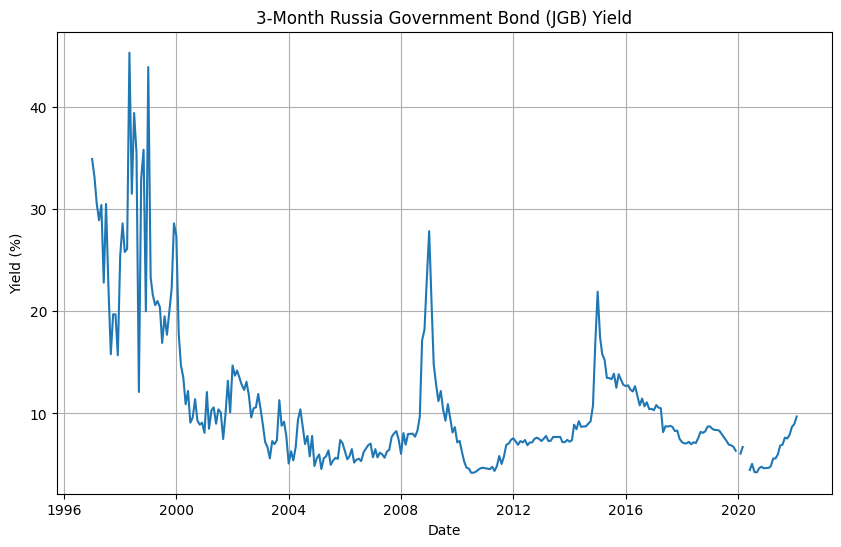

In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_api_key' with your actual FRED API key
api_key = '2f15c96b46530fde1b1992a64c64650e'

# FRED API URL for 3-Month Japanese Government Bond (JGB) yield data
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=IR3TIB01RUM156N&api_key={api_key}&file_type=json'

# Send the request to the API
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    data_points = data['observations']

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data_points, columns=['date', 'value'])
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df['value'])
    plt.title('3-Month Russia Government Bond (JGB) Yield')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.grid()
    plt.show()

else:
    print(f"Error fetching data. Status code: {response.status_code}")


In [7]:
pip install fredapi pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


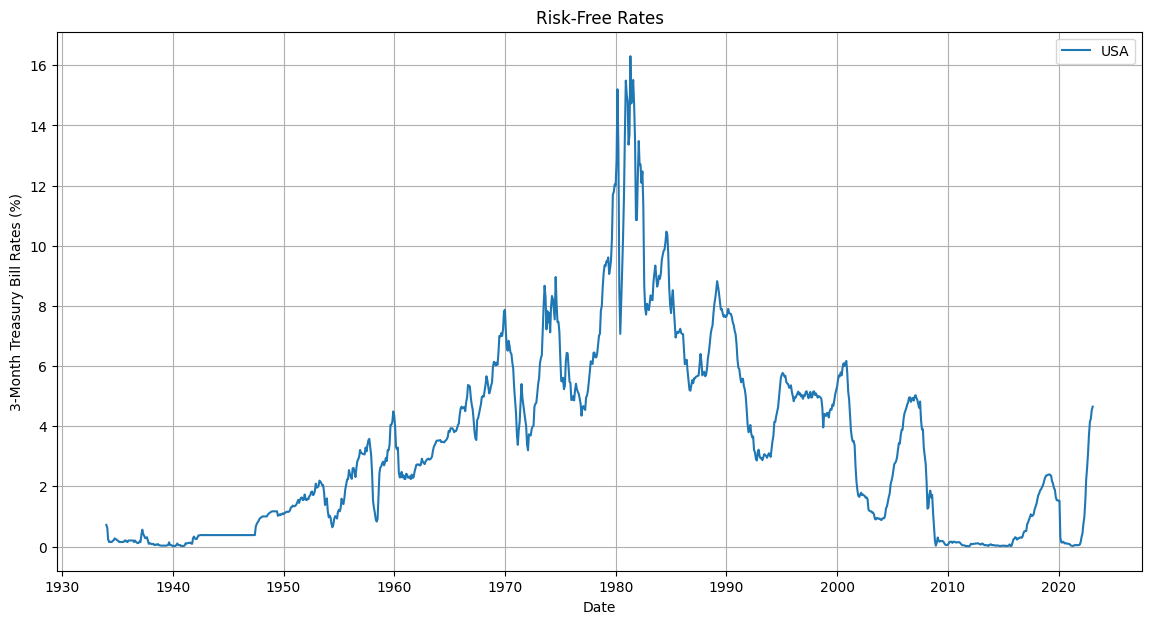

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Replace 'YOUR_API_KEY' with your FRED API key
api_key = '2f15c96b46530fde1b1992a64c64650e'
fred = Fred(api_key=api_key)

# Define the 3-month Treasury bill rate series IDs
series_ids = {
    'USA': 'TB3MS'
}

# Fetch the 3-month Treasury bill rates
data = {}
for country, series_id in series_ids.items():
    data[country] = fred.get_series(series_id)

# Merge the data into a single DataFrame
data_df = pd.concat(data, axis=1)

# Plot the 3-month Treasury bill rates
plt.figure(figsize=(14, 7))
for country in series_ids.keys():
    plt.plot(data_df.index, data_df[country], label=country)

plt.xlabel('Date')
plt.ylabel('3-Month Treasury Bill Rates (%)')
plt.title('Risk-Free Rates')
plt.legend()
plt.grid()
plt.show()
